#conda install -c plotly plotly

In [1]:
# This code calculates the KGE and other stats for comparing EFAS output with observed flow timeseries
import pandas as pd
import numpy as np
from numpy.random import rand
import plotly.express as px
import matplotlib
from calendar import monthrange
from datetime import datetime
# Using graph_objects
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plot
from plotly.subplots import make_subplots
pd.plotting.register_matplotlib_converters()
import plotly.io as pio
pio.renderers.default = "browser"

In [2]:
EfasSel = pd.read_excel('Dis24_Chosen_ky.xlsx', index_col=0)
#station = stations.sample(n=1) # We can randomly choose a station
#EfasSel.set_index('Date', inplace=True)

ObsSel = pd.read_excel('Agi_Chosen_ky.xlsx', index_col=0)
#station = stations.sample(n=1) # We can randomly choose a station
#ObsSel.set_index('Date', inplace=True)

EfasInfo = pd.read_excel('chosen_ky.xlsx', index_col=0)

## Calculate Signatures
Stats = pd.DataFrame()
StatsCalc = pd.DataFrame()

In [3]:
# FDC Signatures
# Sort observed and simulated flows

ObsSelSort = ObsSel.apply(lambda x: x.sort_values(ascending=False).values)
EfasSelSort = EfasSel.apply(lambda x: x.sort_values(ascending=False).values)
leng=len(EfasSelSort)
EfasSelSort['Ind'] = range(1, leng+1)
EfasSelSort['Ind'] = EfasSelSort['Ind'].div(leng)
EfasSelSort.set_index('Ind', inplace=True)
ObsSelSort['Ind'] = range(1, leng+1)
ObsSelSort['Ind'] = ObsSelSort['Ind'].div(leng)
ObsSelSort.set_index('Ind', inplace=True)

ObsSelSortNorm = ObsSelSort.copy()
EfasSelSortNorm = EfasSelSort.copy()

In [4]:
# Normalize by watershed area
for pg in ObsSelSort.columns:
    areas = float(EfasInfo.area[(EfasInfo['stname'] == pg)])
    ObsSelSortNorm[pg] = 1000*(ObsSelSort[pg] / (areas*1000000)) #  convert km2 to m2 than to mm
    EfasSelSortNorm[pg] = 1000*(EfasSelSort[pg] / (areas*1000000))

IndexError: index 15 is out of bounds for axis 0 with size 15

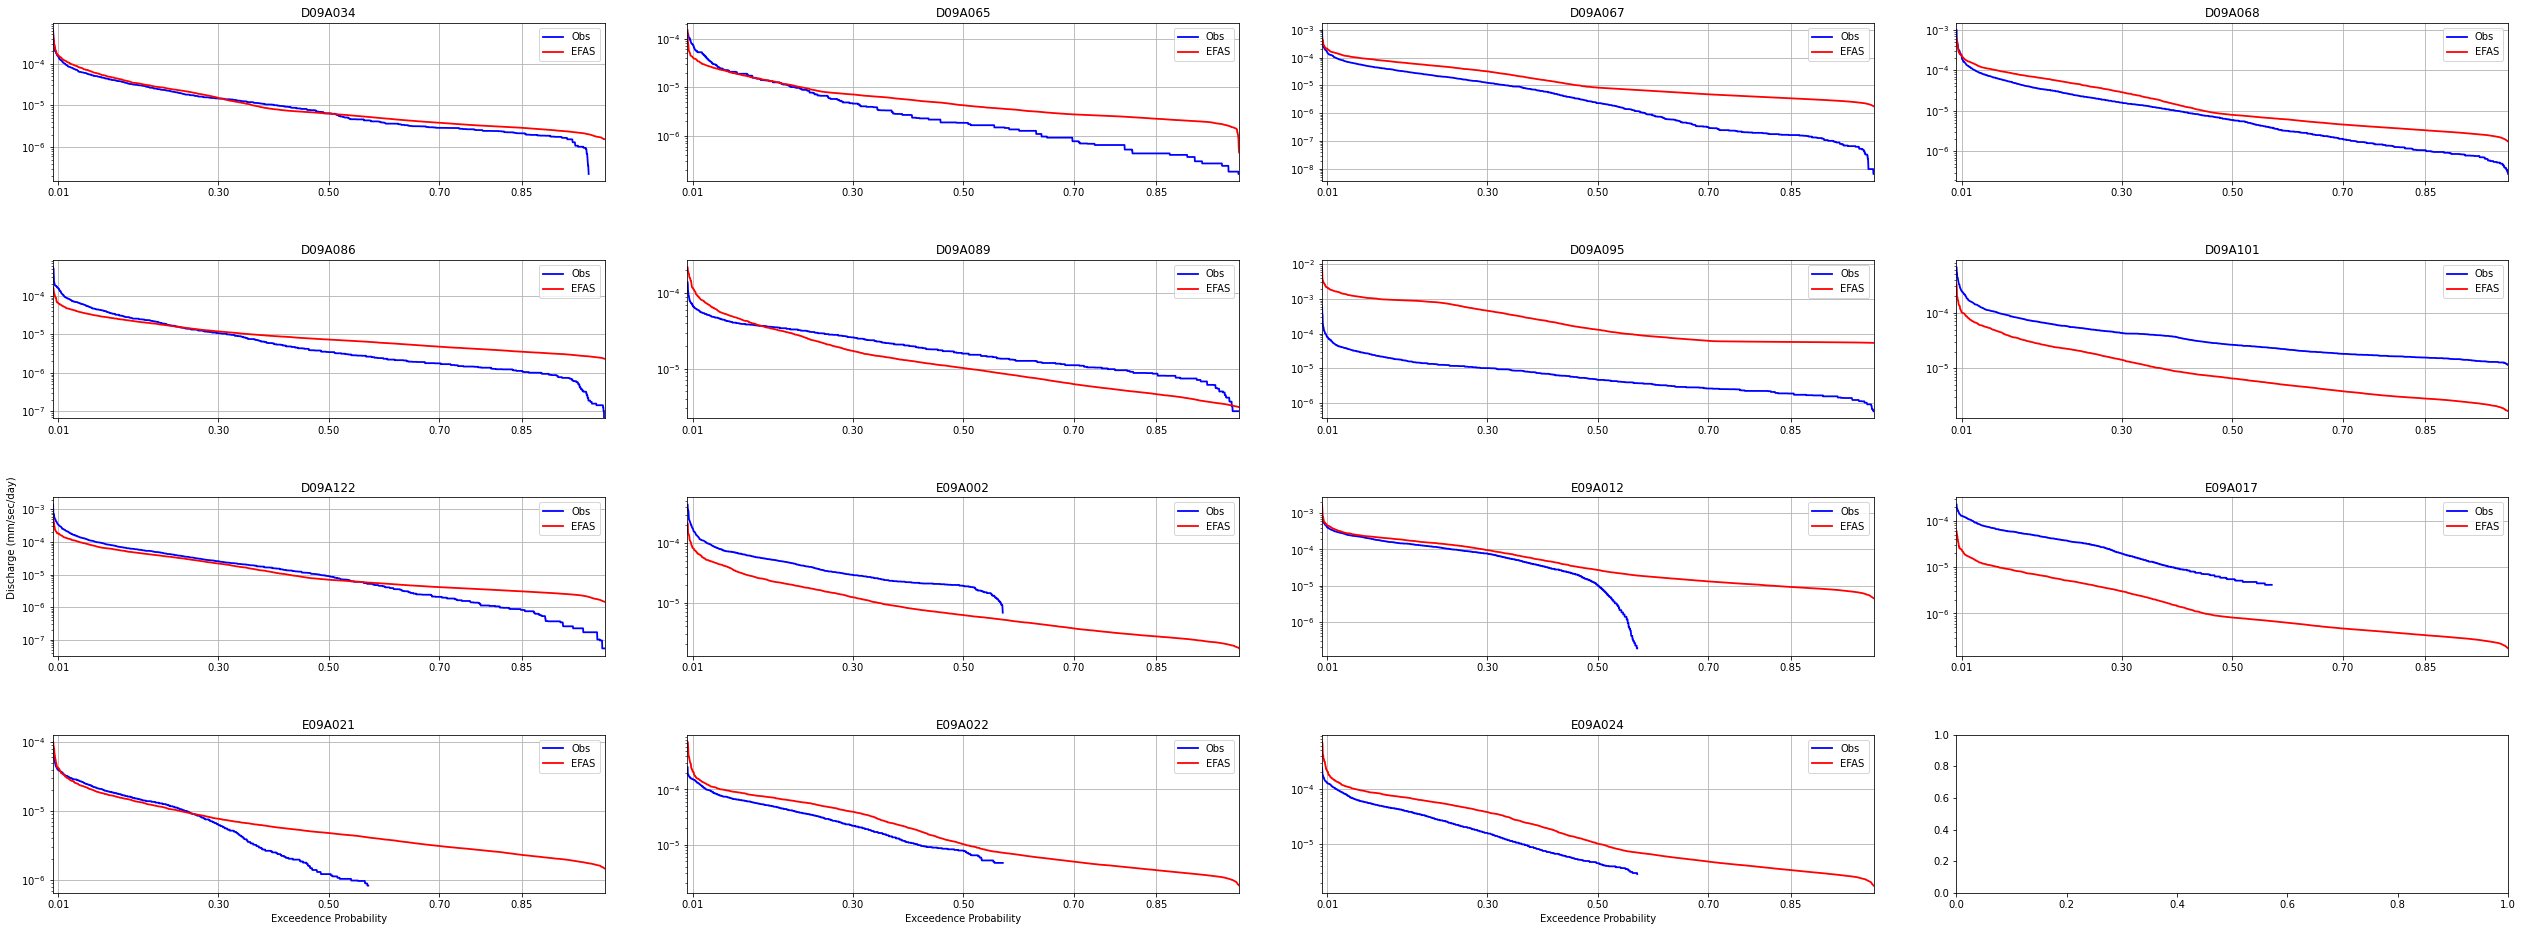

In [5]:
# Plot FDCs
fig, axs = plot.subplots(4,4, figsize=(44, 16), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.15)
axs = axs.ravel()
for i in range(16):
    axs[i].plot(ObsSelSort.columns[i], data=ObsSelSortNorm,  linestyle='-', color='blue', linewidth=1.8, label='Obs')
    axs[i].plot(ObsSelSort.columns[i], data=EfasSelSortNorm,  linestyle='-', color='red', linewidth=1.8, label='EFAS')
    axs[i].set_yscale('log')
    axs[i].set_title(str(ObsSelSort.columns[i]))
    axs[i].set_xticks([0.01, 0.3, 0.5, 0.7, 0.85])
    axs[i].grid()
    axs[i].set_xlim(left=0, right=1)
    axs[i].legend()
    if i == 8:
        axs[i].set_ylabel('                         Discharge (mm/sec/day)', fontsize=10)
    if i > 11:
        axs[i].set_xlabel('Exceedence Probability', fontsize=10)

fig.savefig('FDC_Obs_Sim_Antalya.png')
fig.show()


In [7]:
# Define FDC thresholds
H5 = round(0.01 * len(ObsSelSortNorm)) + 1
H30 = round(0.30 * len(ObsSelSortNorm)) + 1
H50 = round(0.50 * len(ObsSelSortNorm)) + 1
H70 = round(0.70 * len(ObsSelSortNorm)) + 1
H85 = round(0.85 * len(ObsSelSortNorm)) + 1

In [8]:
for pg in ObsSel.columns:
    TSSel = pd.DataFrame()
    TSSel = pd.concat([EfasSelSortNorm[pg], ObsSelSortNorm[pg]], axis=1, ignore_index=True, sort=False)
    TSSel = TSSel.rename(columns={0: "Sim", 1: "Obs"})
    leng = len(TSSel)
    TSSel['Ind'] = range(0, leng )
    TSSel.set_index('Ind', inplace=True)
    # For observed values
    TSSel["H5Obs"] = np.log10(TSSel['Obs'][H5])
    TSSel["H50Obs"] = np.log10(TSSel['Obs'][H50])
    TSSel["H85Obs"] = np.log10(TSSel['Obs'][H85])
    TSSel["HSLObs"] = np.log10(TSSel['Obs'][H30]) - np.log10(TSSel['Obs'][H70])
    # For sim values
    TSSel["H5Sim"] = np.log10(TSSel['Sim'][H5])
    TSSel["H50Sim"] = np.log10(TSSel['Sim'][H50])
    TSSel["H85Sim"] = np.log10(TSSel['Sim'][H85])
    TSSel["HSLSim"] = np.log10(TSSel['Sim'][H30]) - np.log10(TSSel['Sim'][H70])

    StatsCalc = TSSel.iloc[0]
    StatsCalc["Station"] = pg

    Stats = Stats.append(StatsCalc)

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\PC\AppData\Local\Temp/ipykernel_284/4034828815.py:22: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



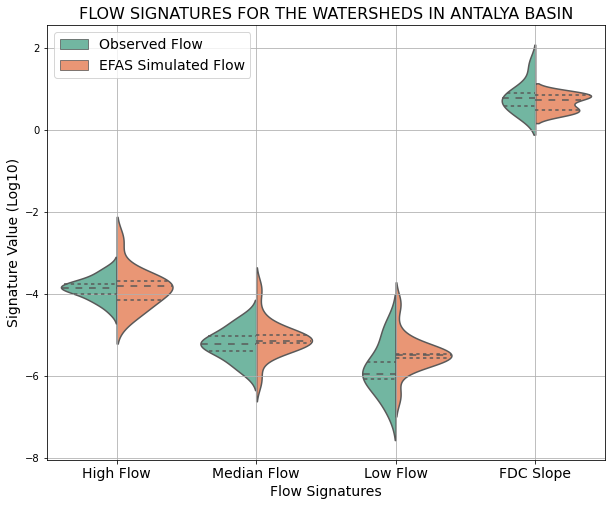

In [9]:
# Export Stats
Stats.to_excel('Stats_Antalya.xlsx')
StatsMeltedObs = Stats.melt(id_vars='Station', value_vars=["H5Obs", "H50Obs", "H85Obs", "HSLObs" ])
StatsMeltedSim = Stats.melt(id_vars='Station', value_vars=["H5Sim", "H50Sim", "H85Sim", "HSLSim" ])
StatsMeltedObs["Type"] = "Observed Flow"
StatsMeltedSim["Type"] = "EFAS Simulated Flow"
StatsMeltedObs['variable'] = StatsMeltedObs['variable'].map(lambda x: x.rstrip('Obs'))
StatsMeltedSim['variable'] = StatsMeltedSim['variable'].map(lambda x: x.rstrip('Sim'))

StatsMelted = pd.concat([StatsMeltedObs, StatsMeltedSim], ignore_index=True)
fig, axv = plot.subplots(figsize=(10,8))
axv = sns.violinplot(x="variable", y="value", hue="Type", data=StatsMelted, palette="Set2", split=True,
                    scale="count", inner="quartile")
axv.grid()
axv.legend(loc=2,prop={'size':14})
labels = [item.get_text() for item in axv.get_xticklabels()]
labels = ['High Flow','Median Flow','Low Flow','FDC Slope']
axv.set_xticklabels(labels, fontsize=14)
axv.set_title('FLOW SIGNATURES FOR THE WATERSHEDS IN ANTALYA BASIN', fontsize=16)
axv.set_ylabel('Signature Value (Log10)', fontsize=14)
axv.set_xlabel('Flow Signatures', fontsize=14)
fig.show()
fig.savefig('FDC_Signatures_Antalya.png')

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\AppData\Local\Temp/ipykernel_284/161077989.py:41: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



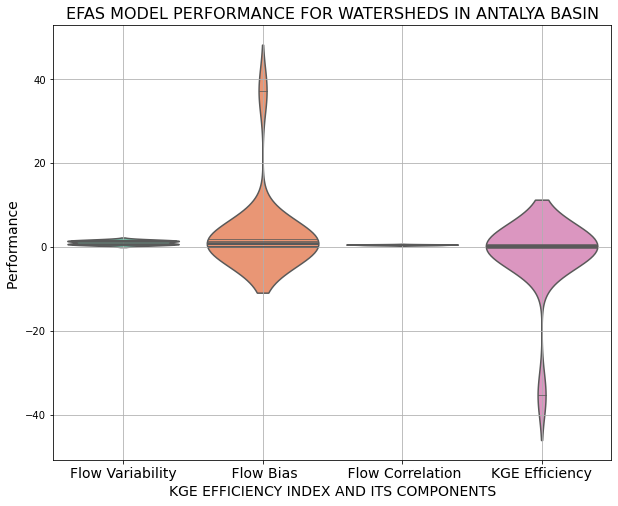

In [10]:
##KGE and Components
KGE = pd.DataFrame()
KGECalc = pd.DataFrame()
for pg in ObsSel.columns:
    TSSel = pd.DataFrame()
    TSSel = pd.concat([EfasSel[pg], ObsSel[pg]], axis=1, ignore_index=True, sort=False)
    TSSel = TSSel.rename(columns={0: "Sim", 1: "Obs"})
    # Calculate KGE Components
    TSSel["MeanObs"] = TSSel["Obs"].mean()
    TSSel["MeanSim"] = TSSel["Sim"].mean()

    TSSel["StdObs"] = TSSel["Obs"].std() / TSSel["MeanObs"]
    TSSel["StdSim"] = TSSel["Sim"].std() / TSSel["MeanSim"]

    TSSel["Alpha"] = TSSel["StdSim"] / TSSel["StdObs"]
    TSSel["Beta"] = TSSel["MeanSim"] / TSSel["MeanObs"]

    TSSel["Corr"] = TSSel["Sim"].corr(TSSel["Obs"])
    TSSel["KGE"] = 1 - ((TSSel["Corr"] - 1)**2 + (TSSel["Alpha"] - 1)**2 + (TSSel["Beta"] - 1)**2)**0.5
    KGECalc = TSSel.iloc[0]
    KGECalc["Station"] = pg

    KGE = KGE.append(KGECalc)

# Export KGE
KGE.to_excel('Stats_KGE_Antalya.xlsx')

# Plot KGE and Components
KGEMelted = KGE.melt(id_vars='Station', value_vars=["Alpha", "Beta", "Corr", "KGE"])

fig, axv = plot.subplots(figsize=(10,8))
axv = sns.violinplot(x="variable", y="value", data=KGEMelted, palette="Set2", split=True,
                    scale="count", inner="stick")
axv.grid()
labels = [item.get_text() for item in axv.get_xticklabels()]
labels = ['Flow Variability',' Flow Bias',' Flow Correlation','KGE Efficiency']
axv.set_xticklabels(labels, fontsize=14)
axv.set_title('EFAS MODEL PERFORMANCE FOR WATERSHEDS IN ANTALYA BASIN', fontsize=16)
axv.set_ylabel('Performance ', fontsize=14)
axv.set_xlabel('KGE EFFICIENCY INDEX AND ITS COMPONENTS', fontsize=14)
fig.show()
fig.savefig('KGE_Components_Antalya.png')

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Fill NaN values with Mean Value of column

In [12]:
ObsSel.isnull().sum().sort_values(ascending = False)

E09A002    1095
E09A012    1095
E09A017    1095
E09A021    1095
E09A022    1095
E09A024    1095
D09A034      74
D09A065       0
D09A067       0
D09A068       0
D09A086       0
D09A089       0
D09A095       0
D09A101       0
D09A122       0
dtype: int64

In [15]:
ObsSel = ObsSel.dropna()

In [16]:
ObsSel.isnull().sum().sort_values(ascending = False)

D09A034    0
D09A065    0
D09A067    0
D09A068    0
D09A086    0
D09A089    0
D09A095    0
D09A101    0
D09A122    0
E09A002    0
E09A012    0
E09A017    0
E09A021    0
E09A022    0
E09A024    0
dtype: int64

In [38]:
filtt = EfasSel.index.isin(ObsSel.T.columns)

In [49]:
EfasSel = EfasSel[filtt]

In [53]:
Beta = []
for i in range(len(ObsSel.columns)):
    
    Beta.append(EfasSel.iloc[:,i].mean()/ObsSel.iloc[:,i].mean())
    print(EfasSel.columns[i], Beta[i])

D09A034 1.1744976551402624
D09A065 1.267870928845915
D09A067 2.026950076241779
D09A068 1.4163559491064757
D09A086 0.990956345300265
D09A089 0.9887898761639977
D09A101 0.38435727706035616
D09A122 0.8415049397949581
E09A002 0.3238558636660388
E09A012 0.7474678167360074
E09A017 0.08843996937072851
E09A021 0.7709447097932783
E09A022 0.8527519792798945
E09A024 1.0444544543762515


In [54]:
Alpha = []
for i in range(len(ObsSel.columns)):
    
    Alpha.append(EfasSel.iloc[:,i].std()/ObsSel.iloc[:,i].std())
    print(EfasSel.columns[i], Alpha[i])

D09A034 1.0907795724528235
D09A065 0.7465590403616585
D09A067 1.2462422791323275
D09A068 0.8494541783440902
D09A086 0.5009633715232009
D09A089 1.6230613195385326
D09A101 0.4677388633734473
D09A122 0.5404244754250868
E09A002 0.4414462137021509
E09A012 0.9737671675566955
E09A017 0.13823278024579735
E09A021 0.8851005680371817
E09A022 1.2206269010465576
E09A024 1.3363963215338508


In [55]:
# Drop D09A095 because its Alpha and Beta are problematic
EfasSel =EfasSel.drop(['D09A095'], axis = 1)
ObsSel =ObsSel.drop(['D09A095'], axis = 1)
print(ObsSel.columns)

KeyError: "['D09A095'] not found in axis"

# Try Above code with corrected data

In [56]:
# FDC Signatures
# Sort observed and simulated flows

ObsSelSort = ObsSel.apply(lambda x: x.sort_values(ascending=False).values)
EfasSelSort = EfasSel.apply(lambda x: x.sort_values(ascending=False).values)
leng=len(EfasSelSort)
EfasSelSort['Ind'] = range(1, leng+1)
EfasSelSort['Ind'] = EfasSelSort['Ind'].div(leng)
EfasSelSort.set_index('Ind', inplace=True)
ObsSelSort['Ind'] = range(1, leng+1)
ObsSelSort['Ind'] = ObsSelSort['Ind'].div(leng)
ObsSelSort.set_index('Ind', inplace=True)

ObsSelSortNorm = ObsSelSort.copy()
EfasSelSortNorm = EfasSelSort.copy()

In [57]:
# Normalize by watershed area
for pg in ObsSelSort.columns:
    areas = float(EfasInfo.area[(EfasInfo['stname'] == pg)])
    ObsSelSortNorm[pg] = 1000*(ObsSelSort[pg] / (areas*1000000)) #  convert km2 to m2 than to mm
    EfasSelSortNorm[pg] = 1000*(EfasSelSort[pg] / (areas*1000000))

IndexError: index 14 is out of bounds for axis 0 with size 14

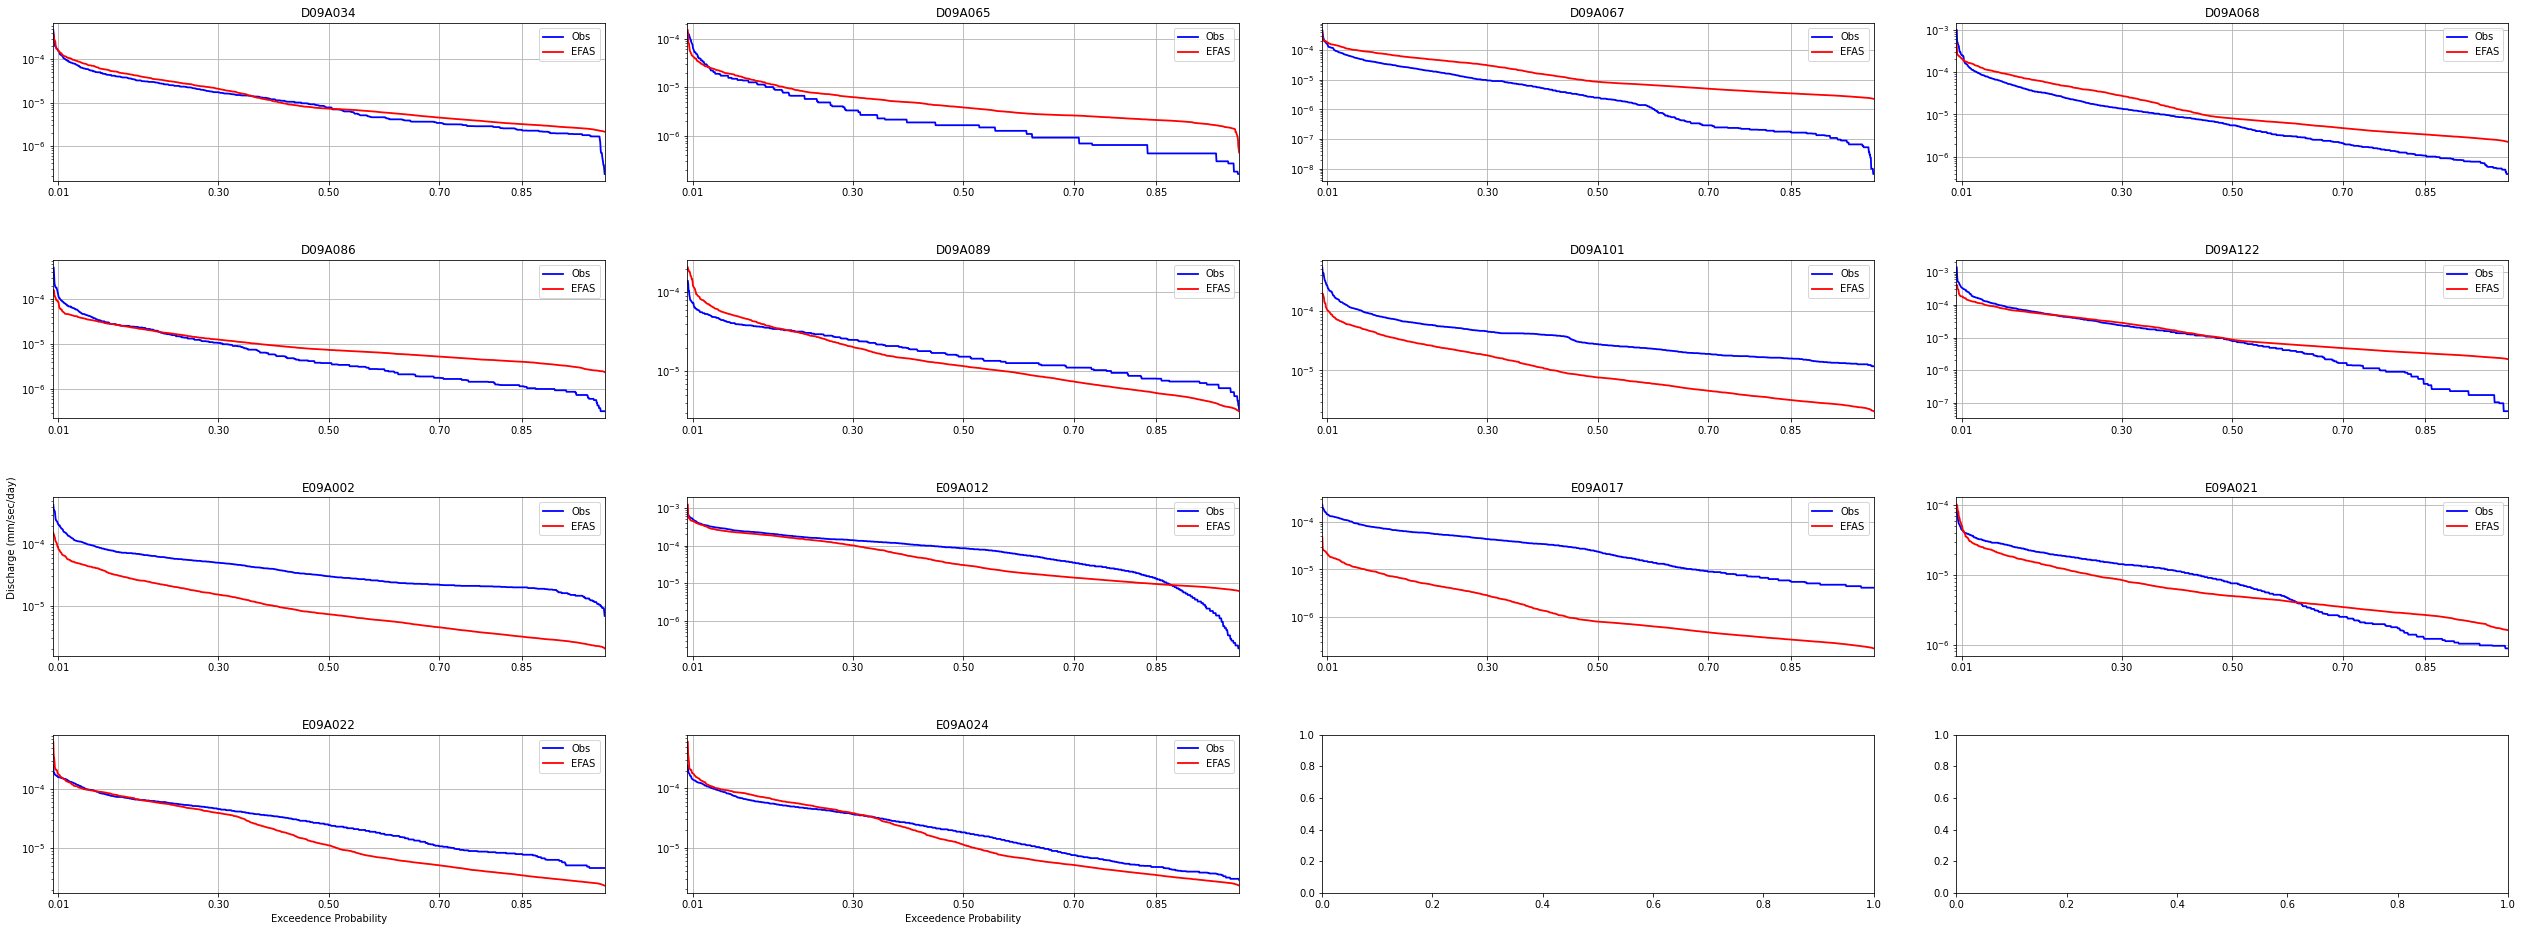

In [58]:
# Plot FDCs
fig, axs = plot.subplots(4,4, figsize=(44, 16), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.15)
axs = axs.ravel()
for i in range(16):
    axs[i].plot(ObsSelSort.columns[i], data=ObsSelSortNorm,  linestyle='-', color='blue', linewidth=1.8, label='Obs')
    axs[i].plot(ObsSelSort.columns[i], data=EfasSelSortNorm,  linestyle='-', color='red', linewidth=1.8, label='EFAS')
    axs[i].set_yscale('log')
    axs[i].set_title(str(ObsSelSort.columns[i]))
    axs[i].set_xticks([0.01, 0.3, 0.5, 0.7, 0.85])
    axs[i].grid()
    axs[i].set_xlim(left=0, right=1)
    axs[i].legend()
    if i == 8:
        axs[i].set_ylabel('                         Discharge (mm/sec/day)', fontsize=10)
    if i > 11:
        axs[i].set_xlabel('Exceedence Probability', fontsize=10)

fig.savefig('FDC_Obs_Sim_Antalya.corrected.png')
fig.show()


In [59]:
# Define FDC thresholds
H5 = round(0.01 * len(ObsSelSortNorm)) + 1
H30 = round(0.30 * len(ObsSelSortNorm)) + 1
H50 = round(0.50 * len(ObsSelSortNorm)) + 1
H70 = round(0.70 * len(ObsSelSortNorm)) + 1
H85 = round(0.85 * len(ObsSelSortNorm)) + 1

In [60]:
for pg in ObsSel.columns:
    TSSel = pd.DataFrame()
    TSSel = pd.concat([EfasSelSortNorm[pg], ObsSelSortNorm[pg]], axis=1, ignore_index=True, sort=False)
    TSSel = TSSel.rename(columns={0: "Sim", 1: "Obs"})
    leng = len(TSSel)
    TSSel['Ind'] = range(0, leng )
    TSSel.set_index('Ind', inplace=True)
    # For observed values
    TSSel["H5Obs"] = np.log10(TSSel['Obs'][H5])
    TSSel["H50Obs"] = np.log10(TSSel['Obs'][H50])
    TSSel["H85Obs"] = np.log10(TSSel['Obs'][H85])
    TSSel["HSLObs"] = np.log10(TSSel['Obs'][H30]) - np.log10(TSSel['Obs'][H70])
    # For sim values
    TSSel["H5Sim"] = np.log10(TSSel['Sim'][H5])
    TSSel["H50Sim"] = np.log10(TSSel['Sim'][H50])
    TSSel["H85Sim"] = np.log10(TSSel['Sim'][H85])
    TSSel["HSLSim"] = np.log10(TSSel['Sim'][H30]) - np.log10(TSSel['Sim'][H70])

    StatsCalc = TSSel.iloc[0]
    StatsCalc["Station"] = pg

    Stats = Stats.append(StatsCalc)

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\PC\AppData\Local\Temp/ipykernel_284/180370898.py:22: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



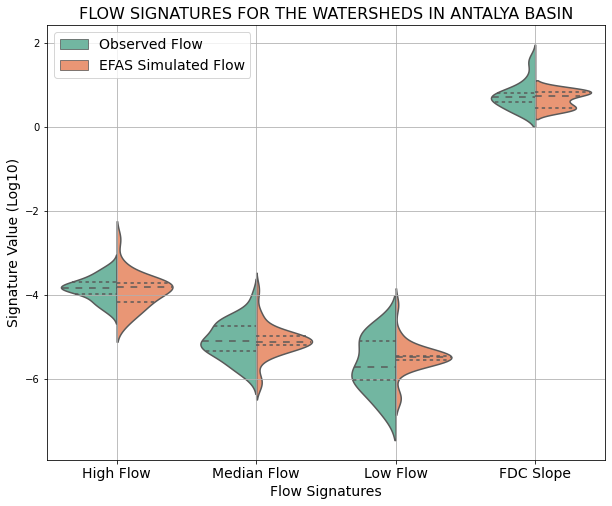

In [61]:
# Export Stats
Stats.to_excel('Stats_Antalya.xlsx')
StatsMeltedObs = Stats.melt(id_vars='Station', value_vars=["H5Obs", "H50Obs", "H85Obs", "HSLObs" ])
StatsMeltedSim = Stats.melt(id_vars='Station', value_vars=["H5Sim", "H50Sim", "H85Sim", "HSLSim" ])
StatsMeltedObs["Type"] = "Observed Flow"
StatsMeltedSim["Type"] = "EFAS Simulated Flow"
StatsMeltedObs['variable'] = StatsMeltedObs['variable'].map(lambda x: x.rstrip('Obs'))
StatsMeltedSim['variable'] = StatsMeltedSim['variable'].map(lambda x: x.rstrip('Sim'))

StatsMelted = pd.concat([StatsMeltedObs, StatsMeltedSim], ignore_index=True)
fig, axv = plot.subplots(figsize=(10,8))
axv = sns.violinplot(x="variable", y="value", hue="Type", data=StatsMelted, palette="Set2", split=True,
                    scale="count", inner="quartile")
axv.grid()
axv.legend(loc=2,prop={'size':14})
labels = [item.get_text() for item in axv.get_xticklabels()]
labels = ['High Flow','Median Flow','Low Flow','FDC Slope']
axv.set_xticklabels(labels, fontsize=14)
axv.set_title('FLOW SIGNATURES FOR THE WATERSHEDS IN ANTALYA BASIN', fontsize=16)
axv.set_ylabel('Signature Value (Log10)', fontsize=14)
axv.set_xlabel('Flow Signatures', fontsize=14)
fig.show()
fig.savefig('FDC_Signatures_Antalya.corrected.png')

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\AppData\Local\Temp/ipykernel_284/2792671941.py:41: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



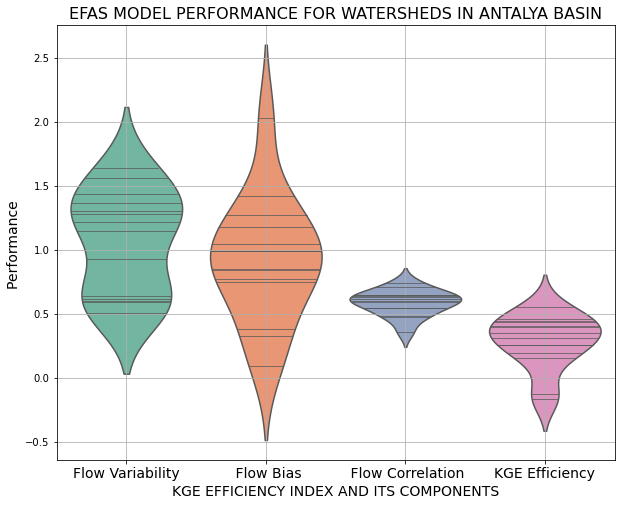

In [63]:
##KGE and Components
KGE = pd.DataFrame()
KGECalc = pd.DataFrame()
for pg in ObsSel.columns:
    TSSel = pd.DataFrame()
    TSSel = pd.concat([EfasSel[pg], ObsSel[pg]], axis=1, ignore_index=True, sort=False)
    TSSel = TSSel.rename(columns={0: "Sim", 1: "Obs"})
    # Calculate KGE Components
    TSSel["MeanObs"] = TSSel["Obs"].mean()
    TSSel["MeanSim"] = TSSel["Sim"].mean()

    TSSel["StdObs"] = TSSel["Obs"].std() / TSSel["MeanObs"]
    TSSel["StdSim"] = TSSel["Sim"].std() / TSSel["MeanSim"]

    TSSel["Alpha"] = TSSel["StdSim"] / TSSel["StdObs"]
    TSSel["Beta"] = TSSel["MeanSim"] / TSSel["MeanObs"]

    TSSel["Corr"] = TSSel["Sim"].corr(TSSel["Obs"])
    TSSel["KGE"] = 1 - ((TSSel["Corr"] - 1)**2 + (TSSel["Alpha"] - 1)**2 + (TSSel["Beta"] - 1)**2)**0.5
    KGECalc = TSSel.iloc[0]
    KGECalc["Station"] = pg

    KGE = KGE.append(KGECalc)

# Export KGE
KGE.to_excel('Stats_KGE_Antalya.xlsx')

# Plot KGE and Components
KGEMelted = KGE.melt(id_vars='Station', value_vars=["Alpha", "Beta", "Corr", "KGE"])

fig, axv = plot.subplots(figsize=(10,8))
axv = sns.violinplot(x="variable", y="value", data=KGEMelted, palette="Set2", split=True,
                    scale="count", inner="stick")
axv.grid()
labels = [item.get_text() for item in axv.get_xticklabels()]
labels = ['Flow Variability',' Flow Bias',' Flow Correlation','KGE Efficiency']
axv.set_xticklabels(labels, fontsize=14)
axv.set_title('EFAS MODEL PERFORMANCE FOR WATERSHEDS IN ANTALYA BASIN', fontsize=16)
axv.set_ylabel('Performance ', fontsize=14)
axv.set_xlabel('KGE EFFICIENCY INDEX AND ITS COMPONENTS', fontsize=14)
fig.show()
fig.savefig('KGE_Components_Antalya.Drop.png')